In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# HW 1 Part 1

In [34]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from scipy.special import factorial
def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

########################################################################################################################
########################################################################################################################
# YOUR ASSSIGMENT STARTS HERE
# FOLLOW THE INSTRUCTION BELOW TO BUILD AND TRAIN A 3-LAYER NEURAL NETWORK
########################################################################################################################
########################################################################################################################
class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z, type):
          
        if type == 'tanh':
            z = (2/(1+np.exp(-2*z)))-1
            #return np.tanh(z)
            return z
        elif type == 'sigmoid':
            z = 1/(1+np.exp(-1*z))
        elif type == 'relu':
          return np.maximum(0, z)
        
        else:
            print("Incorrect function detected,\
                  please enter one of the following functions:\
                  ReLU, Sigmoid or Tanh")
        return z

    def diff_actFun(self, z, type):
        '''
        diff_actFun compute the derivatives of the activation functions wrt the net input
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''

        if type == 'tanh':
            z = (1/np.square(np.cosh(z))) #formula created using tanh^2+sech^2=1
            #return 1 - np.square(np.tanh(z))
            #f = (2/(1+np.exp(-2*z)))-1
            #z = 1 - np.square(f)
            return z
        elif type == 'sigmoid':
            z = np.exp(-z)/(1 + 2*np.exp(-z) + np.exp(-2*z))
        elif type == 'relu':
          return np.where(z > 0, 1, 0)
                
        else:
            print("Incorrect function detected,\
                  please enter one of the following functions:\
                  ReLU, Sigmoid or Tanh")
        return z

    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1
        :param X: input data
        :param actFun: activation function
        :return:
        '''

        # YOU IMPLEMENT YOUR feedforward HERE

        self.z1 = np.dot(X,self.W1) + self.b1
        self.a1 = actFun(self.z1)
        self.z2 = np.dot(self.a1,self.W2) + self.b2

           
        #Version 1 of a2 = ^y = softmax(z2)
        #self.probs = np.exp(self.z2)/ np.sum(np.exp(self.z2),axis = 1, keepdims = True)
        
        #version 2 of a2 = ^y = softmax(z2)   
        A = np.exp(self.z2 - np.max(self.z2))
        B = np.sum(A,axis = 1, keepdims = True)
        result = A / B
        self.probs = result
        
        return None

    def calculate_loss(self, X, y):
        '''
        calculate_loss compute the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))

        # Calculating the loss
        yhat = self.probs #This is the same equation found feedforward function
        data_loss = np.sum(-np.log(yhat[range(num_examples), y]))
        
        

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return (1. / num_examples) * data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop run backpropagation to compute the gradients used to update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''

        # IMPLEMENT YOUR BACKPROP HERE

        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1
        dW2 = (self.a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(self.W2.T) * self.diff_actFun(self.z1, self.actFun_type)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        return dW1, dW2, db1, db2

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X, y)

            # Add derivatives of regularization terms (b1 and b2 don't have regularization terms)
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -epsilon * dW1
            self.b1 += -epsilon * db1
            self.W2 += -epsilon * dW2
            self.b2 += -epsilon * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plot the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)


Loss after iteration 0: 0.560274
Loss after iteration 1000: 0.072179
Loss after iteration 2000: 0.071301
Loss after iteration 3000: 0.071159
Loss after iteration 4000: 0.071190
Loss after iteration 5000: 0.071136
Loss after iteration 6000: 0.071276
Loss after iteration 7000: 0.071090
Loss after iteration 8000: 0.071265
Loss after iteration 9000: 0.071084
Loss after iteration 10000: 0.071090
Loss after iteration 11000: 0.071087
Loss after iteration 12000: 0.071086
Loss after iteration 13000: 0.071069
Loss after iteration 14000: 0.071114
Loss after iteration 15000: 0.071074
Loss after iteration 16000: 0.071113
Loss after iteration 17000: 0.071071
Loss after iteration 18000: 0.071090
Loss after iteration 19000: 0.071219


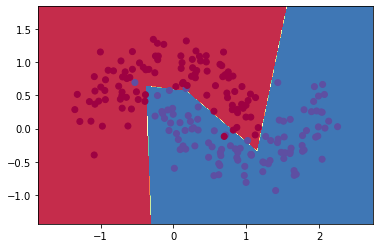

In [35]:
# # generate and visualize Make-Moons dataset
X, y = generate_data()
#plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
#plt.show()

model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3, nn_output_dim=2, actFun_type='relu')
model.fit_model(X,y)
model.visualize_decision_boundary(X,y)


# Adds DeepNeuralNetwork Class

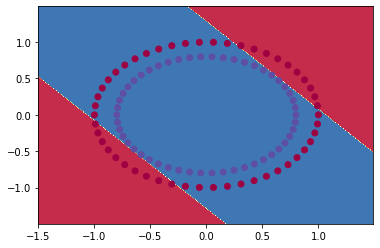

In [134]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from scipy.special import factorial
def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

########################################################################################################################
########################################################################################################################
# YOUR ASSSIGMENT STARTS HERE
# FOLLOW THE INSTRUCTION BELOW TO BUILD AND TRAIN A 3-LAYER NEURAL NETWORK
########################################################################################################################
########################################################################################################################
class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z, type):
          
        if type == 'tanh':
            z = (2/(1+np.exp(-2*z)))-1
            #return np.tanh(z)
            return z
        elif type == 'sigmoid':
            z = 1/(1+np.exp(-1*z))
        elif type == 'relu':
          return np.maximum(0, z)
        
        else:
            print("Incorrect function detected,\
                  please enter one of the following functions:\
                  ReLU, Sigmoid or Tanh")
        return z

    def diff_actFun(self, z, type):
        '''
        diff_actFun compute the derivatives of the activation functions wrt the net input
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''

        if type == 'tanh':
            z = (1/np.square(np.cosh(z))) #formula created using tanh^2+sech^2=1
            #return 1 - np.square(np.tanh(z))
            #f = (2/(1+np.exp(-2*z)))-1
            #z = 1 - np.square(f)
            return z
        elif type == 'sigmoid':
            z = np.exp(-z)/(1 + 2*np.exp(-z) + np.exp(-2*z))
        elif type == 'relu':
          return np.where(z > 0, 1, 0)
                
        else:
            print("Incorrect function detected,\
                  please enter one of the following functions:\
                  ReLU, Sigmoid or Tanh")
        return z

    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1
        :param X: input data
        :param actFun: activation function
        :return:
        '''

        # YOU IMPLEMENT YOUR feedforward HERE

        self.z1 = np.dot(X,self.W1) + self.b1
        self.a1 = actFun(self.z1)
        self.z2 = np.dot(self.a1,self.W2) + self.b2

           
        #Version 1 of a2 = ^y = softmax(z2)
        #self.probs = np.exp(self.z2)/ np.sum(np.exp(self.z2),axis = 1, keepdims = True)
        
        #version 2 of a2 = ^y = softmax(z2)   
        A = np.exp(self.z2 - np.max(self.z2))
        B = np.sum(A,axis = 1, keepdims = True)
        result = A / B
        self.probs = result
        
        return None

    def calculate_loss(self, X, y):
        '''
        calculate_loss compute the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))

        # Calculating the loss
        yhat = self.probs #This is the same equation found feedforward function
        data_loss = np.sum(-np.log(yhat[range(num_examples), y]))
        
        

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return (1. / num_examples) * data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop run backpropagation to compute the gradients used to update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''

        # IMPLEMENT YOUR BACKPROP HERE

        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1
        dW2 = (self.a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(self.W2.T) * self.diff_actFun(self.z1, self.actFun_type)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        return dW1, dW2, db1, db2

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X, y)

            # Add derivatives of regularization terms (b1 and b2 don't have regularization terms)
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -epsilon * dW1
            self.b1 += -epsilon * db1
            self.W2 += -epsilon * dW2
            self.b2 += -epsilon * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plot the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)




class DeepNeuralNetwork(object):
    """
    This class builds and trains a deep neural network
    """

    def __init__(self, nn_dims, actFun_type='tanh', reg_lambda=0.01, seed=0):

        self.nn_dims = nn_dims
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda

        # initialize the weights and biases in the network
        self.W = []
        self.b = []

        np.random.seed(seed)
        for i in range(len(nn_dims)-1):
            self.W.append(np.random.randn(self.nn_dims[i], self.nn_dims[i+1])
                          / np.sqrt(self.nn_dims[i]))
            self.b.append(np.zeros((1, self.nn_dims[i+1])))

    def actFun(self, z, type):
          
        if type == 'tanh':
            z = (2/(1+np.exp(-2*z)))-1
            #return np.tanh(z)
            return z
        elif type == 'sigmoid':
            z = 1/(1+np.exp(-1*z))
        elif type == 'relu':
          return np.maximum(0, z)
        
        else:
            print("Incorrect function detected,\
                  please enter one of the following functions:\
                  ReLU, Sigmoid or Tanh")
        return z

    def diff_actFun(self, z, type):


        if type == 'tanh':
            z = (1/np.square(np.cosh(z))) #formula created using tanh^2+sech^2=1
            #return 1 - np.square(np.tanh(z))
            #f = (2/(1+np.exp(-2*z)))-1
            #z = 1 - np.square(f)
            return z
        elif type == 'sigmoid':
            z = np.exp(-z)/(1 + 2*np.exp(-z) + np.exp(-2*z))
        elif type == 'relu':
          return np.where(z > 0, 1, 0)
                
        else:
            print("Incorrect function detected,\
                  please enter one of the following functions:\
                  ReLU, Sigmoid or Tanh")
        return z

    def feedforward(self, X, actFun):

        self.a = []
        self.z = []
        for i in range(len(self.W)):
            if i == 0:
                self.z.append(np.dot(X, self.W[i]) + self.b[i])
            else:
                self.z.append(np.dot(self.a[i-1], self.W[i]) + self.b[i])
            if i != len(self.W) - 1:
                self.a.append(actFun(self.z[i]))
        C = np.exp(self.z[len(self.z)-1])
        self.probs = C / np.sum(C, axis=1, keepdims=True)
        return None

    def calculate_loss(self, X, y):

        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        # Calculating the loss

        probs = np.exp(self.z[len(self.z)-1]) / \
                np.sum(np.exp(self.z[len(self.z)-1]), axis=1, keepdims=True)
        loss = -np.log(probs[range(num_examples), y])
        final_data_loss = np.sum(loss)

        # Add regulatization term 
        W_sum = 0
        for i in len(self.W):
            W_sum += np.sum(np.square(self.W[i]))
        final_data_loss += self.reg_lambda / 2 * W_sum
        return (1. / num_examples) * final_data_loss

    def predict(self, X):

        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):


        num_examples = len(X)
        delta = self.probs
        delta[range(num_examples), y] -= 1

        db = []
        dW = []
        for num in range(len(self.z)):
            i = len(self.z) - num - 1
            if i != 0:
                dW.insert(0, np.dot(self.a[i - 1].T, delta))
                db.insert(0, np.sum(delta, axis=0, keepdims=True))
                delta = np.dot(delta, self.W[i].T) * \
                        self.diff_actFun(self.z[i-1], type=self.actFun_type)
            else:
                db.insert(0, np.sum(delta, axis=0, keepdims=False))
                dW.insert(0, np.dot(X.T, delta))

        return dW, db

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):

        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            dW, db = self.backprop(X, y)

            # Add regularization terms 
            for i in range(len(dW)):
                dW[i] += self.reg_lambda * self.W[i]

            # Gradient descent parameter update
            for i in range(len(self.W)):
                self.W[i] += -epsilon * dW[i]
                self.b[i] += -epsilon * db[i]
               
            # print the loss.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):

        plot_decision_boundary(lambda x: self.predict(x), X, y)

def main():

    # # generate and visualize Make-Moons dataset
    #X, y = generate_data()
    # # generate and visualize Make-Circles dataset
    X, y = datasets.make_circles(n_samples=100, shuffle=True, noise=None, random_state=None, factor=0.8)

    #Train the Neural Network Model
    model = DeepNeuralNetwork(nn_dims=[2,10,8,8,5], actFun_type='sigmoid')
    model.fit_model(X,y)
    model.visualize_decision_boundary(X,y)

if __name__ == "__main__":
    main()